In [1]:
from subprocess import Popen, PIPE
from pathlib import Path
import time
import shutil
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
JAVA_PATH = 'java'
JAR_PATH = 'target/sem11-java-bonus-1.0-SNAPSHOT-jar-with-dependencies.jar'
ARG_PREFIX = [JAVA_PATH, '-jar', JAR_PATH]
SERVER_TYPES = ['blocking', 'nonblocking', 'async']
PORT = '4444'

In [3]:
experiment_descs = pd.DataFrame(columns=['request_size', 'n_clients', 'request_delay_ms', 'n_requests_per_client'])
if Path('results').exists():
    shutil.rmtree('results')
Path('results').mkdir()

In [4]:
def run_experiment(request_size: int, n_clients: int, request_delay_ms: int, n_requests_per_client: int):
    global experiment_descs
    experiment_id = len(experiment_descs)
    experiment_descs.loc[experiment_id] = {
        'request_size': request_size,
        'n_clients': n_clients,
        'request_delay_ms': request_delay_ms,
        'n_requests_per_client': n_requests_per_client
    }
    
    for server_type in SERVER_TYPES:
        server_proc = None
        client_procs = []
        dir = Path('results') / f'{experiment_id:04}' / server_type
        dir.mkdir(parents=True, exist_ok=True)
    
        with (dir / 'server.csv').open('w') as proc_out:
            args = ARG_PREFIX + [server_type, PORT, str(n_clients)]
            server_proc = Popen(args, stdout=proc_out)

        # Секунды должно хватить, чтобы запустить сервер
        time.sleep(1)
    
        with (dir / 'clients.csv').open('w') as client_out:
            client_out.write('total_ns\n')
            for i in range(n_clients):
                args = ARG_PREFIX + ['client', 'localhost', PORT, str(request_size), str(request_delay_ms), str(n_requests_per_client)]
                proc = Popen(args, stdout=PIPE, stderr=PIPE, encoding='utf8')
                client_procs.append(proc)
        
            for i, proc in enumerate(client_procs):
                outs, errs = proc.communicate()
                if errs != '':
                    print('Error of client', i)
                    print(errs)
                    continue
                assert proc.returncode == 0
                # Конкатенируем клиентов
                client_out.write(outs)
            assert server_proc.wait() == 0

    return experiment_id

In [5]:
fixed_request_size = 4096
fixed_n_clients = 20
fixed_request_delay_ms = 50
fixed_n_requests_per_client = 20

In [6]:
# run_experiment(request_size=1024, n_clients=8, request_delay_ms=50, n_requests_per_client=10)

In [7]:
by_request_size = []
for k in tqdm([2 ** i for i in range(4, 15)]):
    id = run_experiment(
        request_size=k,
        n_clients=fixed_n_clients,
        request_delay_ms=fixed_request_delay_ms,
        n_requests_per_client=fixed_n_requests_per_client)
    by_request_size.append(id)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:04<00:00, 11.30s/it]


In [8]:
by_n_clients = []
for k in tqdm([1, 2, 5, 10, 20, 50, 100, 200]):
    id = run_experiment(
        request_size=fixed_request_size,
        n_clients=k,
        request_delay_ms=fixed_request_delay_ms,
        n_requests_per_client=fixed_n_requests_per_client)
    by_n_clients.append(id)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:21<00:00, 17.74s/it]


In [9]:
by_request_delay_ms = []
for k in tqdm([0, 10, 20, 50, 100, 200]):
    id = run_experiment(
        request_size=fixed_request_size,
        n_clients=fixed_n_clients,
        request_delay_ms=k,
        n_requests_per_client=fixed_n_requests_per_client)
    by_request_delay_ms.append(id)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:19<00:00, 13.24s/it]


In [10]:
by_n_requests_per_client = []
for k in tqdm([10, 20, 50, 100, 200, 500]):
    id = run_experiment(
        request_size=fixed_request_size,
        n_clients=fixed_n_clients,
        request_delay_ms=fixed_request_delay_ms,
        n_requests_per_client=k)
    by_n_requests_per_client.append(id)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:09<00:00, 51.60s/it]


In [11]:
experiment_descs.to_csv('results/experiments.csv', index_label='experiment_id')

In [12]:
def plot_results(experiments: pd.DataFrame, column: str):
    experiments = experiments.copy()
    for experiment_id in experiments.index:
        for server_type in SERVER_TYPES:
            dir = Path('results') / f'{experiment_id:04}' / server_type
            stats_server = pd.read_csv(dir / 'server.csv')
            stats_client = pd.read_csv(dir / 'clients.csv')

            stats_server_m = stats_server.median()
            stats_client_m = stats_client.median() / experiments.loc[experiment_id, 'n_requests_per_client']

            experiments.loc[experiment_id, f'{server_type}_processing_ms'] = 1e-6 * stats_server_m['processing_ns']
            experiments.loc[experiment_id, f'{server_type}_response_ms']   = 1e-6 * stats_server_m['response_ns']
            experiments.loc[experiment_id, f'{server_type}_client_ms']     = 1e-6 * stats_client_m['total_ns']

    fig, axes = plt.subplots(1, 3, dpi=144, figsize=(24, 6))
    for ax in axes:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    for i, what in enumerate(['processing_ms', 'response_ms', 'client_ms']):
        experiments.plot(
            x=column,
            y=[f'{server_type}_{what}' for server_type in SERVER_TYPES],
            label=SERVER_TYPES,
            ylabel=what, ax=axes[i]
        )

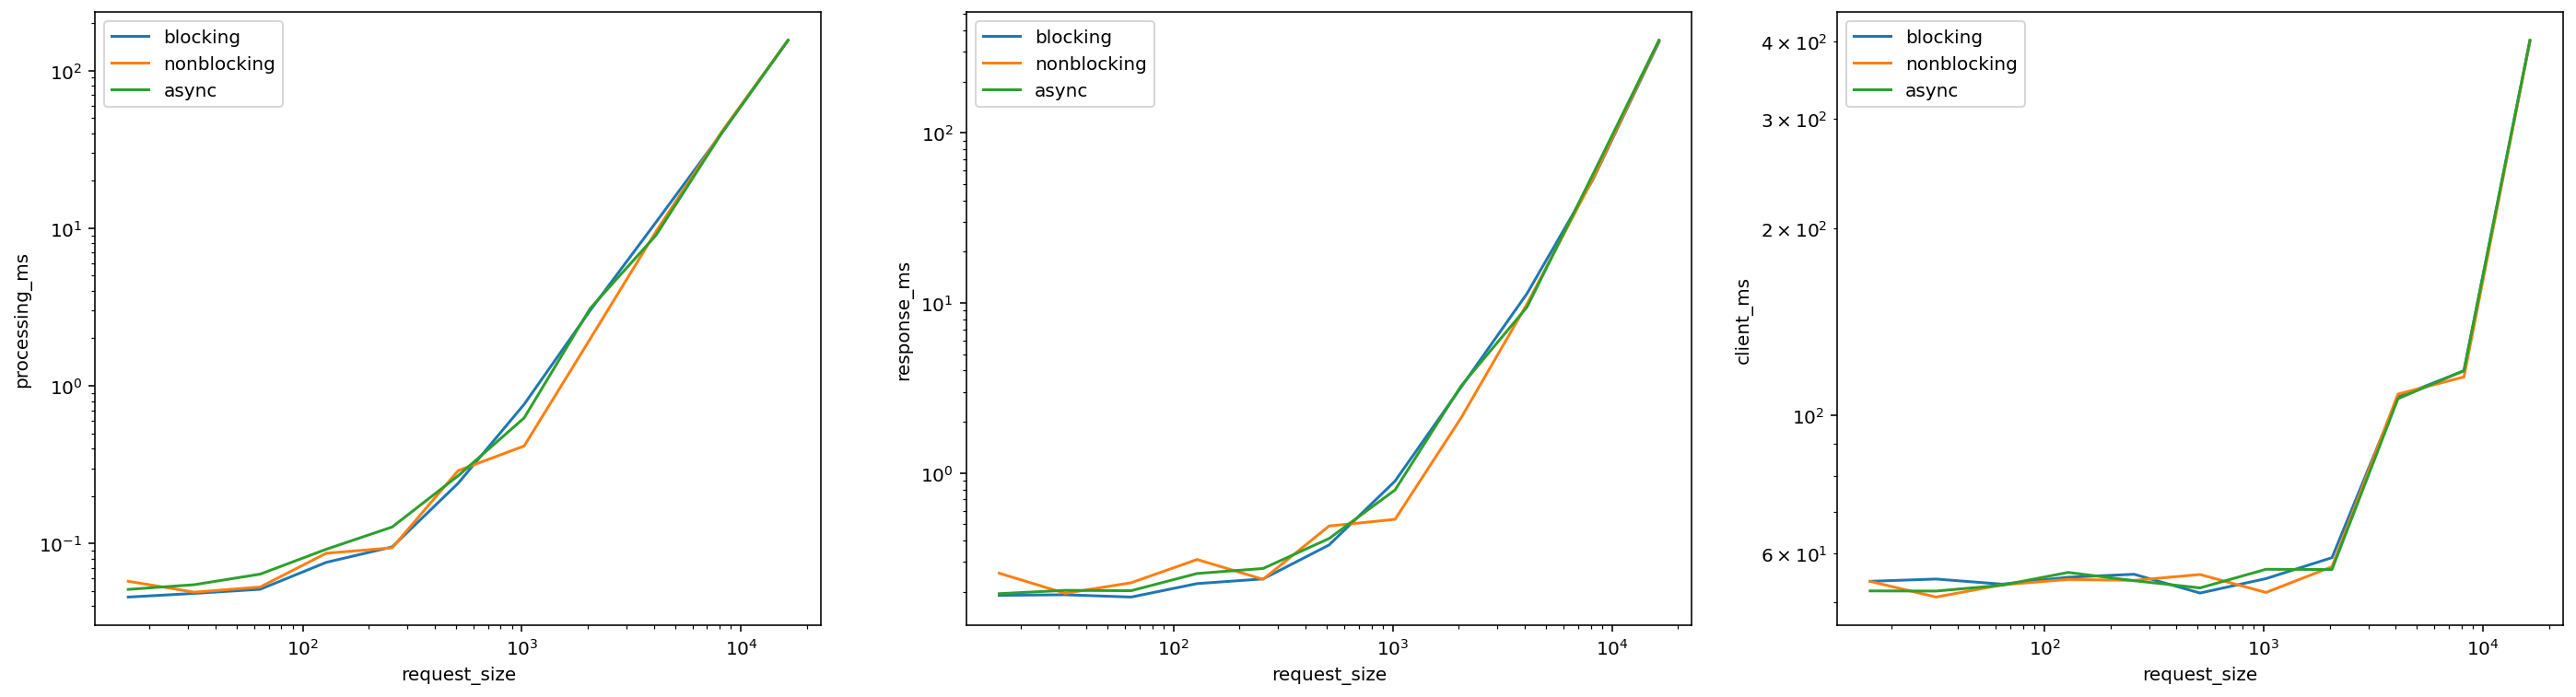

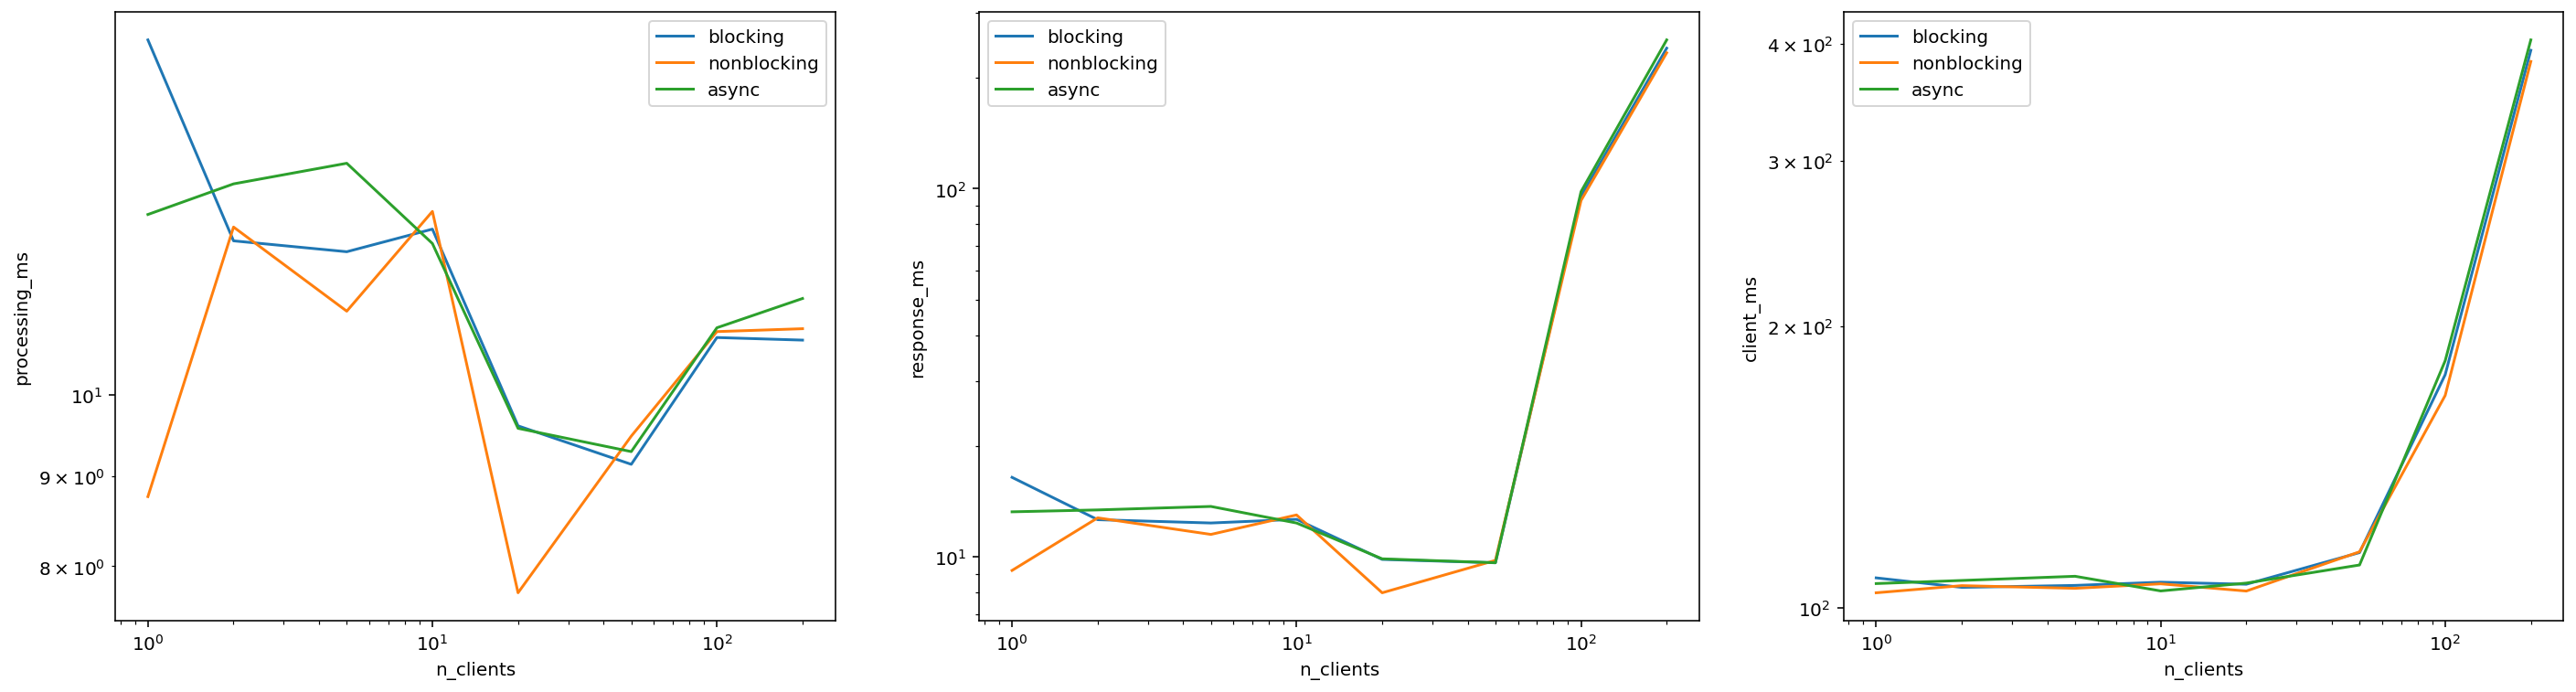

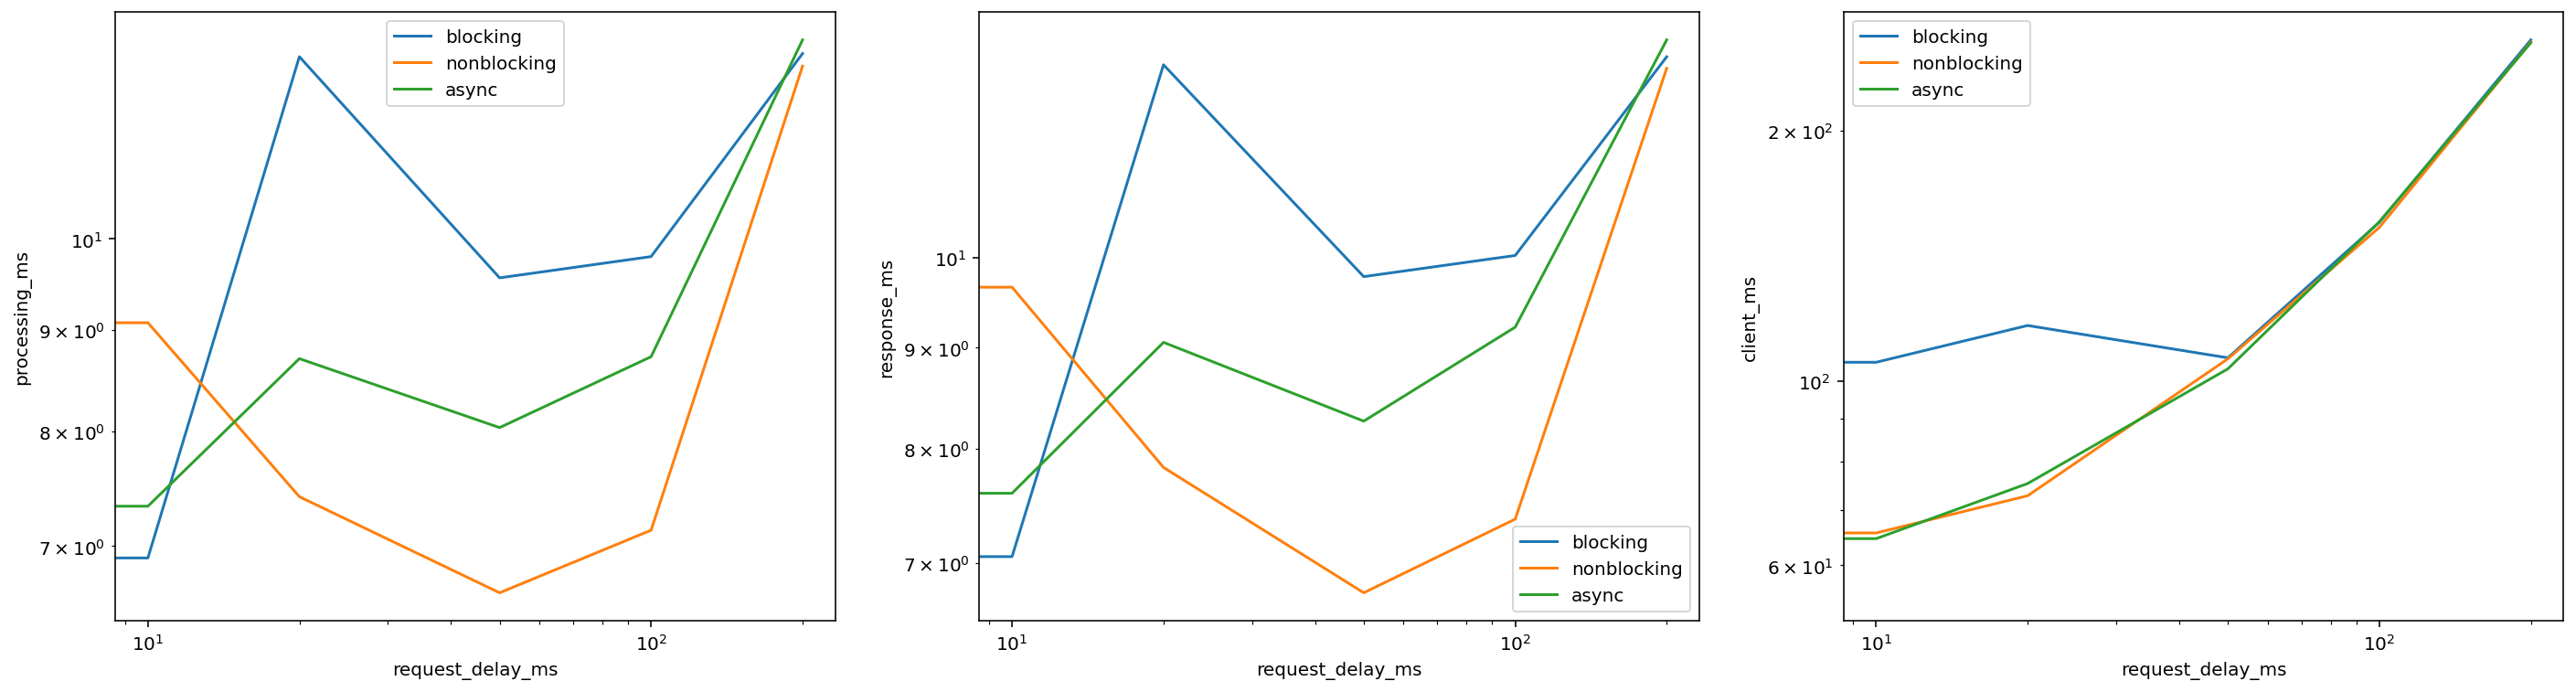

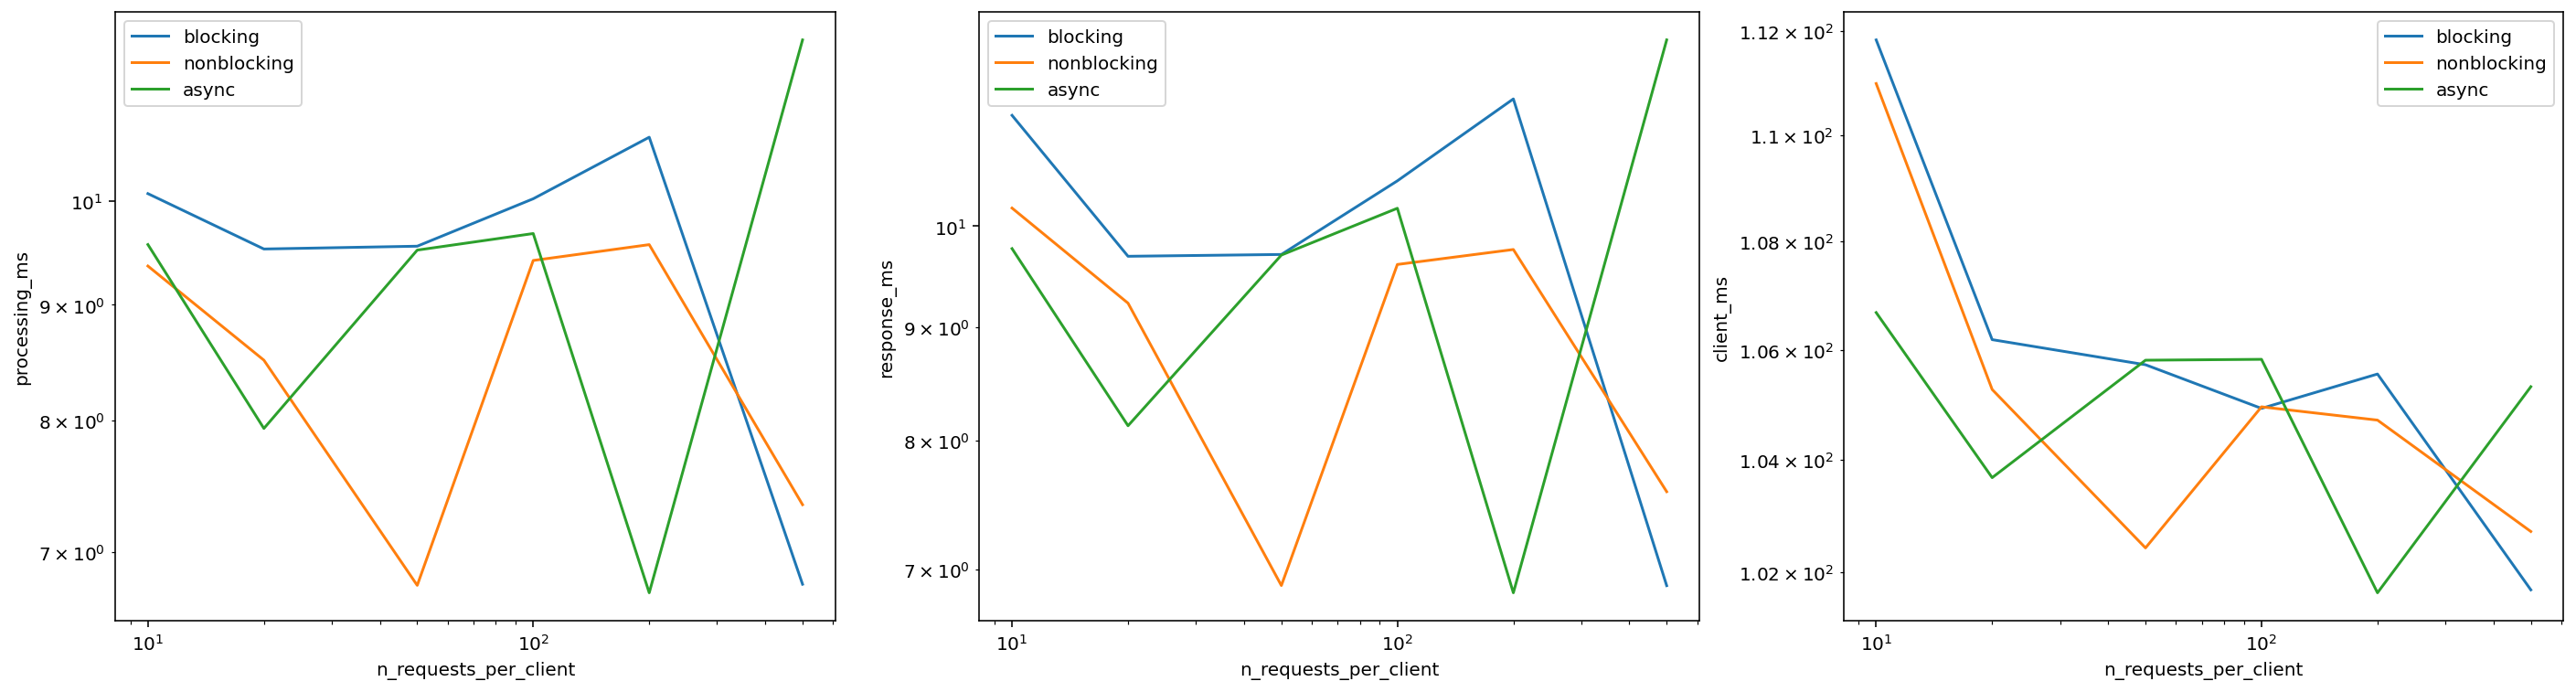

In [13]:
plot_results(experiment_descs.loc[by_request_size, :], 'request_size')
plot_results(experiment_descs.loc[by_n_clients, :], 'n_clients')
plot_results(experiment_descs.loc[by_request_delay_ms, :], 'request_delay_ms')
plot_results(experiment_descs.loc[by_n_requests_per_client, :], 'n_requests_per_client')